# Laboratoire 2 : Arbre de désision, Bayes naïf et KNN
#### Département du génie logiciel et des technologies de l’information

| Étudiants             |                                                         |
|-----------------------|---------------------------------------------------------|
| Jean-Philippe Decoste |  DECJ19059105                                           |
| Ahmad Al-Taher        |   ALTA22109307                                          |
| Stéphanie Lacerte     |   LACS06629109                                          |
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2018                                            |
| Groupe                | 2                                                       |
| Numéro du laboratoire | 02                                                      |
| Professeur            | Hervé Lombaert                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 30 oct 2018                                             |

### Classes et librairies utilisées

In [18]:
import csv
import math
import os

import graphviz
import matplotlib.pyplot as plt
import numpy as np
from image import Image as imageObj
from imageV2 import Image as imageFeat
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from spam import Spam
import utilities
from tabulate import tabulate

## Paramètres de l'application

In [19]:
#LAB01
IMAGE_CSV_NAME = r"data\csv\galaxy\galaxy_label_data_set.csv"
IMAGETEST_CSV_NAME = r"data\csv\galaxy\galaxy_label_data_set_test.csv"

#Galaxy features
EXTRATED_GALAXY_PRIMITIVE = r"data\csv\eq07_pExtraction.csv"
MERGED_GALAXY_PRIMITIVE = r"data\csv\eq07_pMerged.csv"
ALL_GALAXY_PRIMITIVE = r"data\csv\galaxy\galaxy_feature_vectors.csv"

#Spam features
ALL_SPAM_PRIMITIVE = r"data\csv\spam\spam.csv"

#Algo params
TREE_DEPTH = [None, 3, 5, 10]
EXTRACT_TREE_PDF = False
N_NEIGHBORS = [3, 5, 10]
WEIGHTS = ['uniform', 'distance']
VALIDATION_METHOD = ['Holdout', 'Stratified Shuffle Split']

#General config
PRIMITIVE_SCANNING = True
DOMERGE = False
PRINT_GRAPH = True

### Arbre de décision

In [20]:
def decisionTree():
    """
    Algorithme 'Decision Tree' utilisé pour classer les données qui lui sont fourni
    Args:
        --
    """
    validationCounter = 1
    for method in VALIDATION_METHOD:
        validation =  None
        if method == 'Holdout':
            validation = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        elif method == 'Stratified Shuffle Split':
            validation = StratifiedShuffleSplit()
        
        print(str(validationCounter)+".Training with "+method+"\n")
        dTreePerf = [['Depth', 'Accuracy', 'Precision', 'F1']]
        params = dict(max_depth=TREE_DEPTH)
        grid = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=validation, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')

        #Fit data to Decision Tree algo
        grid.fit(features, answers)

        #Loop through results
        precision = []
        score_f1 = []
        for i in range(0, 4):
            dTreePerf.append([grid.cv_results_['params'][i]['max_depth'],
                              "{0:.2f}".format(grid.cv_results_['mean_test_accuracy'][i]*100),
                              "{0:.2f}".format(grid.cv_results_['mean_test_precision'][i]*100),
                              "{0:.2f}".format(grid.cv_results_['mean_test_f1'][i]*100)])
            precision.append(grid.cv_results_['mean_test_accuracy'][i])
            score_f1.append(grid.cv_results_['mean_test_f1'][i])
            
        print(tabulate(dTreePerf, headers="firstrow"))
        print("\nThe best is depth = %s" %(grid.best_params_['max_depth']))
        print()
        
        utilities.printGraph('Profondeur de l\'arbre', 'Précision', [0, 3, 5, 10], precision, [])
        utilities.printGraph('Profondeur de l\'arbre', 'Score F1', [0, 3, 5, 10], score_f1, [])
        validationCounter += 1
    
    print(str(validationCounter)+".Training best params with 10-fold cross-validation\n")
    dTreePerf = [['Depth', 'Accuracy', 'Precision', 'F1']]
    params = dict(max_depth=[grid.best_params_['max_depth']])
    bestGrid = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=10, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')
    
    #Fit data to Decision Tree algo
    bestGrid.fit(features, answers)
    
    dTreePerf.append([bestGrid.cv_results_['params'][0]['max_depth'],
                      "{0:.2f}".format(bestGrid.cv_results_['mean_test_accuracy'][0]*100),
                      "{0:.2f}".format(bestGrid.cv_results_['mean_test_precision'][0]*100),
                      "{0:.2f}".format(bestGrid.cv_results_['mean_test_f1'][0]*100)])
    
    print(tabulate(dTreePerf, headers="firstrow"))
    print("-> Done\n\n")

### KNN

In [21]:
def knn():
    """
    Algorithme 'KNN' utilisé pour classer les données qui lui sont fourni
    Args:
        --
    """
    validationCounter = 1
    for method in VALIDATION_METHOD:
        validation =  None
        if method == 'Holdout':
            validation = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        elif method == 'Stratified Shuffle Split':
            validation = StratifiedShuffleSplit()
            
        print(str(validationCounter)+".Training with "+method+"\n")
        knnPerf = [['Weights', 'K', 'Accuracy', 'Precision', 'F1']]
        params = dict(n_neighbors=N_NEIGHBORS, weights=WEIGHTS, algorithm=['auto'])
        grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=validation, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')

        #Fit data to knn algo
        grid.fit(features, answers)

        #Loop through results
        precision_un = []
        score_f1_un = []
        precision_di = []
        score_f1_di = []
        for i in range(0, 6):
            knnPerf.append([grid.cv_results_['params'][i]['weights'],
                            grid.cv_results_['params'][i]['n_neighbors'],
                            "{0:.2f}".format(grid.cv_results_['mean_test_accuracy'][i]*100),
                            "{0:.2f}".format(grid.cv_results_['mean_test_precision'][i]*100),
                            "{0:.2f}".format(grid.cv_results_['mean_test_f1'][i]*100)])
            if grid.cv_results_['params'][i]['weights'] == 'uniform':
                precision_un.append(grid.cv_results_['mean_test_accuracy'][i])
                score_f1_un.append(grid.cv_results_['mean_test_f1'][i])
            elif grid.cv_results_['params'][i]['weights'] == 'distance':
                precision_di.append(grid.cv_results_['mean_test_accuracy'][i])
                score_f1_di.append(grid.cv_results_['mean_test_f1'][i])

        print(tabulate(knnPerf, headers="firstrow"))
        print("\nThe best is KNN %s With K = %s" %(grid.best_params_['weights'], grid.best_params_['n_neighbors']))
        print()
        
        utilities.printGraph('K', 'Précision', [3, 5, 10], precision_un, precision_di)
        utilities.printGraph('K', 'Score F1', [3, 5, 10], score_f1_un, score_f1_di)
        validationCounter += 1
    
    print("\n"+str(validationCounter)+".Training best params with 10-fold cross-validation\n")
    knnPerf = [['Weights', 'K', 'Accuracy', 'Precision', 'F1']]
    params = dict(n_neighbors=[grid.best_params_['n_neighbors']], weights=[grid.best_params_['weights']], algorithm=['auto'])
    bestGrid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=10, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')
    
    #Fit data to knn algo
    bestGrid.fit(features, answers)
    
    knnPerf.append([bestGrid.cv_results_['params'][0]['weights'],
                    bestGrid.cv_results_['params'][0]['n_neighbors'],
                    "{0:.2f}".format(bestGrid.cv_results_['mean_test_accuracy'][0]*100),
                    "{0:.2f}".format(bestGrid.cv_results_['mean_test_precision'][0]*100),
                    "{0:.2f}".format(bestGrid.cv_results_['mean_test_f1'][0]*100)])
    
    print(tabulate(knnPerf, headers="firstrow"))
    print("-> Done\n\n")

### Bayes (MultinomialNB)

In [22]:
def bayes():
    validationCounter = 1
    for method in VALIDATION_METHOD:
        validation =  None
        if method == 'Holdout':
            validation = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        elif method == 'Stratified Shuffle Split':
            validation = StratifiedShuffleSplit()
            
        print(str(validationCounter)+".Training with "+method+"\n")
        bayesPerf = [['Data type', 'Accuracy', 'Precision', 'F1']]
        params = dict()
        grid = GridSearchCV(MultinomialNB(), param_grid=params, cv=validation, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')

        #Scale the data between 0 and 1
        scaler = preprocessing.MinMaxScaler()
        scaler.fit(features)
        xNormalized = scaler.transform(features)

        #Fit normalized data to Bayes algo
        grid.fit(xNormalized, answers)
        bayesPerf.append(['Normalized',
                          "{0:.2f}".format(float(grid.cv_results_['mean_test_accuracy'])*100),
                          "{0:.2f}".format(float(grid.cv_results_['mean_test_precision'])*100),
                          "{0:.2f}".format(float(grid.cv_results_['mean_test_f1'])*100)])
        precision_norm = grid.cv_results_['mean_test_accuracy']
        score_f1_norm = grid.cv_results_['mean_test_f1']

        #Discretize normalized data
        est = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
        est.fit(features)
        xKBinsDiscretizer = est.transform(features)

        #Fit discretize data to bayes algorithm
        grid.fit(xKBinsDiscretizer, answers)
        bayesPerf.append(['Discretized',
                            "{0:.2f}".format(float(grid.cv_results_['mean_test_accuracy'])*100),
                            "{0:.2f}".format(float(grid.cv_results_['mean_test_precision'])*100),
                            "{0:.2f}".format(float(grid.cv_results_['mean_test_f1'])*100)])
        precision_disct = grid.cv_results_['mean_test_accuracy']
        score_f1_disct = grid.cv_results_['mean_test_f1']

        print(tabulate(bayesPerf, headers="firstrow"))
        label = "Discritized"
        if precision_norm > precision_disct:
            label = "Normalized"
            print("\nThe best is Bayes with %s data" %(label))
        print()
        
        utilities.printGraph('Type de données', 'Précision', [0.3], precision_norm, precision_disct)
        utilities.printGraph('Type de données', 'Score F1', [0.8], score_f1_norm, score_f1_disct)
        validationCounter += 1
    
    print("\n"+str(validationCounter)+".Training with 10-fold cross-validation\n")
    bayesPerf = [['Data type', 'Accuracy', 'Precision', 'F1']]
    params = dict()
    bestGrid = GridSearchCV(MultinomialNB(), param_grid=params, cv=10, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')
    
    #Fit data to Bayes algo    
    bestGrid.fit(xNormalized, answers)
    bayesPerf.append(['Normalized',
                        "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_accuracy'])*100),
                        "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_precision'])*100),
                        "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_f1'])*100)])
    
    bestGrid.fit(xKBinsDiscretizer, answers)    
    bayesPerf.append(['Discretized',
                        "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_accuracy'])*100),
                        "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_precision'])*100),
                        "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_f1'])*100)])
    
    print(tabulate(bayesPerf, headers="firstrow"))
    print("-> Done\n\n")

### Bayes (GaussianNB)

In [23]:
def bayesGaussian():
    validationCounter = 1
    for method in VALIDATION_METHOD:
        validation =  None
        if method == 'Holdout':
            validation = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        elif method == 'Stratified Shuffle Split':
            validation = StratifiedShuffleSplit()
            
        print(str(validationCounter)+".Training with "+method+"\n")
        bayesPerf = [['Accuracy', 'Precision', 'F1']]
        params = dict()
        holdoutValidation = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        grid = GridSearchCV(GaussianNB(), param_grid=params, cv=validation, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')

        #Fit normalized data to Bayes algo
        grid.fit(features, answers)
        bayesPerf.append(["{0:.2f}".format(float(grid.cv_results_['mean_test_accuracy'])*100),
                          "{0:.2f}".format(float(grid.cv_results_['mean_test_precision'])*100),
                          "{0:.2f}".format(float(grid.cv_results_['mean_test_f1'])*100)])

        print(tabulate(bayesPerf, headers="firstrow"))
        print()
        
        validationCounter += 1
    
    print("\n"+str(validationCounter)+".Training with 10-fold cross-validation\n")
    bayesPerf = [['Accuracy', 'Precision', 'F1']]
    params = dict()
    bestGrid = GridSearchCV(GaussianNB(), param_grid=params, cv=10, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')
    
    #Fit data to Bayes algo
    bestGrid.fit(features, answers)
    
    bayesPerf.append(["{0:.2f}".format(float(bestGrid.cv_results_['mean_test_accuracy'])*100),
                      "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_precision'])*100),
                      "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_f1'])*100)])
    
    print(tabulate(bayesPerf, headers="firstrow"))
    print("-> Done\n\n")

In [24]:
def lab2_prepareDataset(datasetName, dataset):
    print("PREPARING DATASETS")
    allData_length = len(list(csv.reader(open(dataset))))
    progress = 0
    datas = []

    print("Reading " + datasetName + " features:")
    utilities.printProgressBar(0, allData_length, prefix='Progress:', suffix='Complete', length=50)
    with open(dataset, 'r') as theFile:
        primitives = csv.reader(theFile, delimiter=',', quotechar='|')

        for row in primitives:
            progress += 1
            utilities.printProgressBar(progress+1, allData_length, prefix='Progress', suffix='Complete', length=50)

            values = [float(i) for i in row]
            if datasetName == "Galaxy":
                datas.append(imageFeat(values))
            elif datasetName == "Spam":
                datas.append(Spam(values))
    print("\n-> Done\n")

    #3. Split dataset using model_selection
    for data in np.array(datas):
        features.append(data.features)
        answers.append(data.answer)

PREPARING DATASETS
Reading Galaxy features:
Progress |**************************************************| 100.0% Complete
-> Done

ALGORITHMS

Decision Tree:
1.Training with Holdout

  Depth    Accuracy    Precision     F1
-------  ----------  -----------  -----
              90.98        91.36  91.34
      3       86.55        86.04  87.27
      5       89.95        91.33  90.23
     10       91.78        92.44  92.08

The best is depth = 10



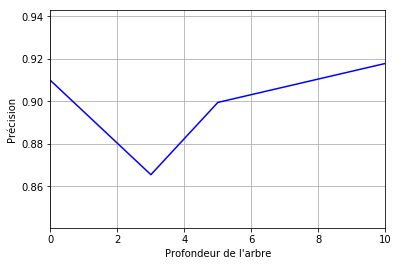

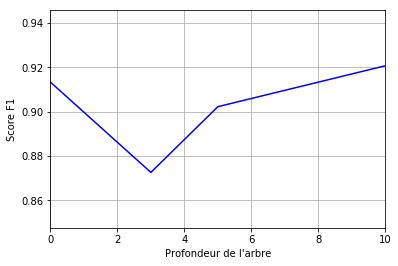

2.Training with Stratified Shuffle Split

  Depth    Accuracy    Precision     F1
-------  ----------  -----------  -----
              90.18        90.51  90.54
      3       85.58        84.93  86.34
      5       89.1         90.94  89.3
     10       91.25        91.43  91.59

The best is depth = 10



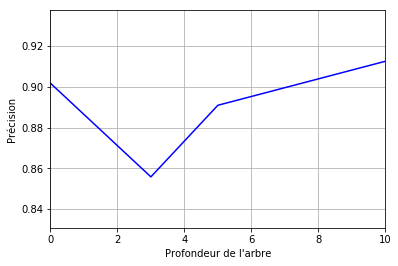

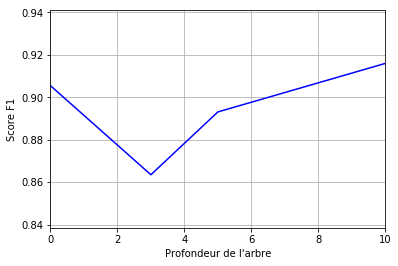

3.Training best params with 10-fold cross-validation

  Depth    Accuracy    Precision     F1
-------  ----------  -----------  -----
     10       91.58           92  91.88
-> Done


KNN:
1.Training with Holdout

Weights      K    Accuracy    Precision     F1
---------  ---  ----------  -----------  -----
uniform      3       59.2         61.12  60.28
distance     3       58.81        60.97  59.49
uniform      5       60.2         61.9   61.59
distance     5       59.67        61.63  60.67
uniform     10       59.76        62.97  58.8
distance    10       60.7         62.33  62.17

The best is KNN distance With K = 10



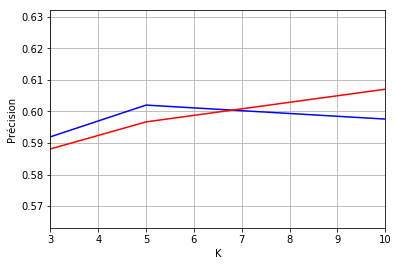

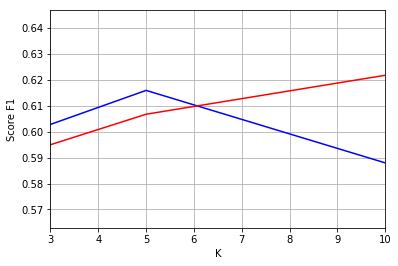

2.Training with Stratified Shuffle Split

Weights      K    Accuracy    Precision     F1
---------  ---  ----------  -----------  -----
uniform      3       58.8         60.48  60.06
distance     3       59           60.89  59.87
uniform      5       59.28        60.69  60.97
distance     5       59.05        60.74  60.28
uniform     10       58.92        62.04  57.69
distance    10       59.72        61.04  61.54

The best is KNN distance With K = 10



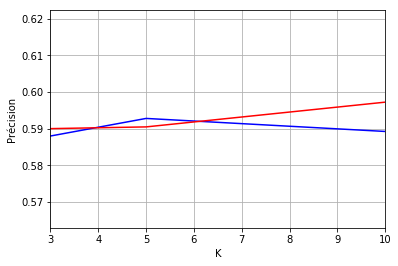

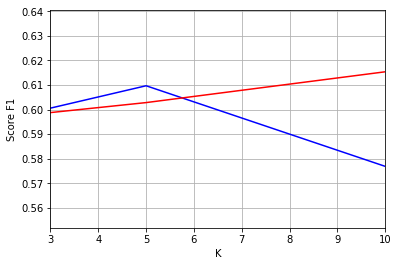


3.Training best params with 10-fold cross-validation

Weights      K    Accuracy    Precision     F1
---------  ---  ----------  -----------  -----
distance    10       60.21        61.52  61.93
-> Done



Bayes MultinomialNB
1.Training with Holdout

Data type      Accuracy    Precision     F1
-----------  ----------  -----------  -----
Normalized        81.14        80.9   82.17
Discretized       75.64        79.56  75.37

The best is Bayes with Normalized data



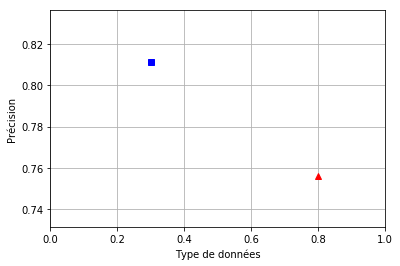

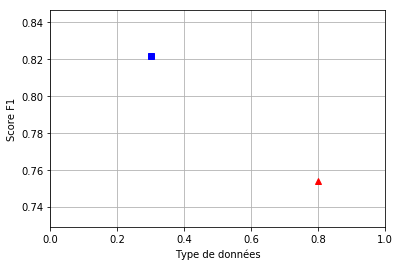

2.Training with Stratified Shuffle Split

Data type      Accuracy    Precision     F1
-----------  ----------  -----------  -----
Normalized        79.82        79.29  80.99
Discretized       75.88        79.35  75.71

The best is Bayes with Normalized data



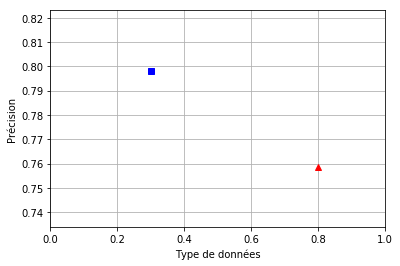

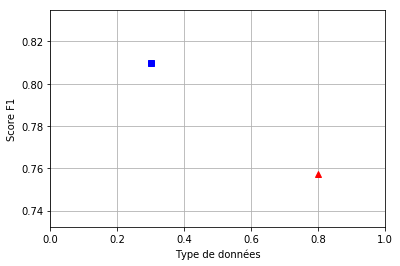


3.Training with 10-fold cross-validation

Data type      Accuracy    Precision     F1
-----------  ----------  -----------  -----
Normalized        79.93        79.34  81.09
Discretized       75.85        79.38  75.63
-> Done



Bayes GaussianNB
1.Training with Holdout

  Accuracy    Precision     F1
----------  -----------  -----
      79.8         85.6  79.15

2.Training with Stratified Shuffle Split

  Accuracy    Precision     F1
----------  -----------  -----
     79.27        85.13  78.47


3.Training with 10-fold cross-validation

  Accuracy    Precision    F1
----------  -----------  ----
      79.7        85.28    79
-> Done


PREPARING DATASETS
Reading Spam features:
Progress |**************************************************| 100.0% Complete
-> Done

ALGORITHMS

Decision Tree:
1.Training with Holdout

  Depth    Accuracy    Precision     F1
-------  ----------  -----------  -----
              88.95        86.67  86.47
      3       86.23        83.78  83.04
      5       

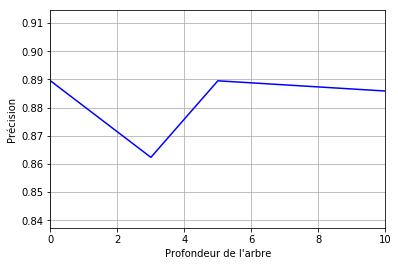

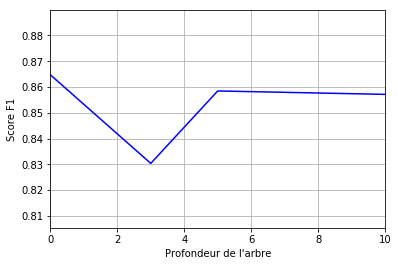

2.Training with Stratified Shuffle Split

  Depth    Accuracy    Precision     F1
-------  ----------  -----------  -----
              91.16        89.87  88.83
      3       89.13        88.86  85.98
      5       90.8         92.97  87.87
     10       91.01        90.96  88.46

The best is depth = None



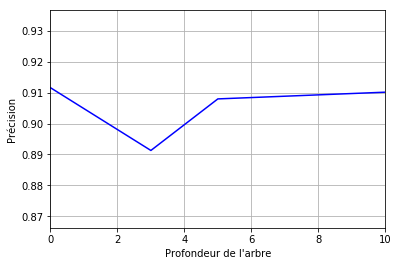

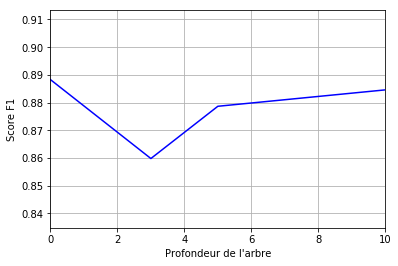

3.Training best params with 10-fold cross-validation

Depth      Accuracy    Precision     F1
-------  ----------  -----------  -----
              90.72        88.25  88.42
-> Done


KNN:
1.Training with Holdout

Weights      K    Accuracy    Precision     F1
---------  ---  ----------  -----------  -----
uniform      3       76.81        72.27  71.3
distance     3       78.44        73.99  73.5
uniform      5       78.26        74.09  73.09
distance     5       79.89        76.02  75.17
uniform     10       76.09        75     68.12
distance    10       80.62        77.93  75.63

The best is KNN distance With K = 10



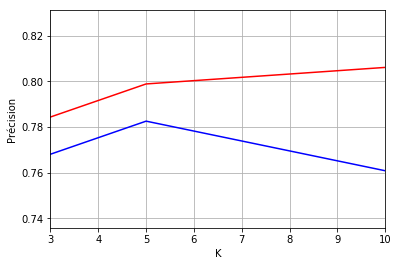

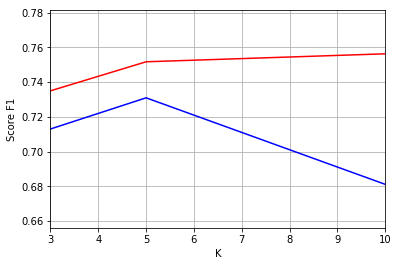

2.Training with Stratified Shuffle Split

Weights      K    Accuracy    Precision     F1
---------  ---  ----------  -----------  -----
uniform      3       79.17        75.06  73.56
distance     3       80.98        76.98  76.04
uniform      5       78.88        74.25  73.34
distance     5       80.87        76.58  75.96
uniform     10       77.86        75.17  70.81
distance    10       81.3         77.36  76.45

The best is KNN distance With K = 10



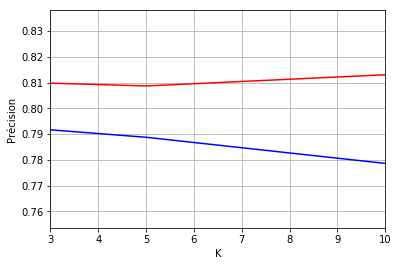

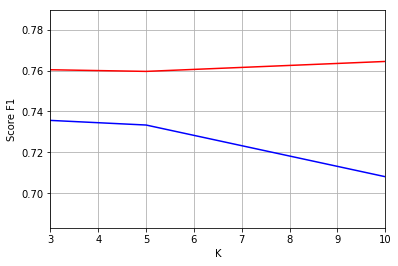


3.Training best params with 10-fold cross-validation

Weights      K    Accuracy    Precision     F1
---------  ---  ----------  -----------  -----
distance    10       80.76        75.63  76.19
-> Done



Bayes MultinomialNB
1.Training with Holdout

Data type      Accuracy    Precision    F1
-----------  ----------  -----------  ----
Normalized        90.04        93.4   87
Discretized       67.93        82.67  41.2

The best is Bayes with Normalized data



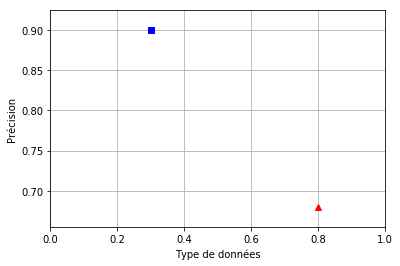

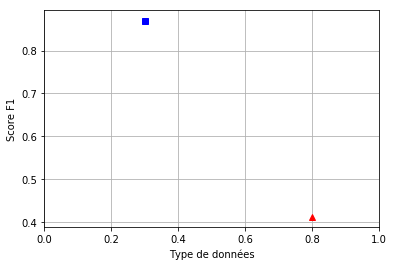

2.Training with Stratified Shuffle Split

Data type      Accuracy    Precision     F1
-----------  ----------  -----------  -----
Normalized        90.4         94.3   87.01
Discretized       68.55        82.02  41.14

The best is Bayes with Normalized data



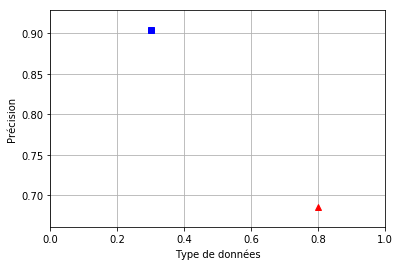

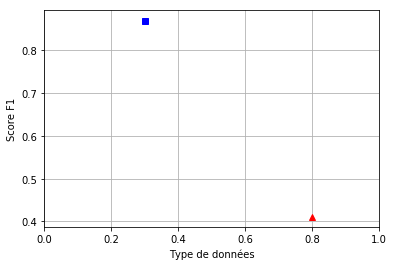


3.Training with 10-fold cross-validation

Data type      Accuracy    Precision     F1
-----------  ----------  -----------  -----
Normalized        89.82        93.39  86.23
Discretized       67.72        79.79  39.4
-> Done



Bayes GaussianNB
1.Training with Holdout

  Accuracy    Precision     F1
----------  -----------  -----
     82.25        70.78  81.65

2.Training with Stratified Shuffle Split

  Accuracy    Precision     F1
----------  -----------  -----
      79.6        67.76  78.61


3.Training with 10-fold cross-validation

  Accuracy    Precision     F1
----------  -----------  -----
     81.23        69.43  80.31
-> Done




In [25]:
#0. Generate new feature files for Galaxy (only run once)
#utilities.lab1_extractFeatures()

#1.A Read Galaxy features (name of file, path, n_split, test size, random state)
features = []
answers = []
if os.path.isfile(MERGED_GALAXY_PRIMITIVE):
    lab2_prepareDataset("Galaxy", MERGED_GALAXY_PRIMITIVE)
else:
    lab2_prepareDataset("Galaxy", ALL_GALAXY_PRIMITIVE)

#2.A Execute Algorithm
print("ALGORITHMS")
#2.1. DECISION TREE
print("\nDecision Tree:")
decisionTree()
#2.2. KNN
print("KNN:")
knn()
#2.3. BAYES
print("\nBayes MultinomialNB")
bayes()
print("\nBayes GaussianNB")
bayesGaussian()



#3.B Read Spams features (name of file, path, n_split, test size, random state)
features = []
answers = []
lab2_prepareDataset("Spam", ALL_SPAM_PRIMITIVE)

#4.B Execute Algorithm
print("ALGORITHMS")
#4.1. DECISION TREE
print("\nDecision Tree:")
decisionTree()
#4.2. KNN
print("KNN:")
knn()
#4.3. BAYES
print("\nBayes MultinomialNB")
bayes()
print("\nBayes GaussianNB")
bayesGaussian()


# Analyse

## Question 1
### Méthode de création des ensembles de données

Premièrement, lors du lancement de l’application, celle-ci vérifie si le fichier de données contenant les primitives fournit avec ceux du premier laboratoire. Si tel est le cas, on vérifie que ce fichier comprend le même nombre de lignes que le fichier d’images fournies. Dans le cas où le compte n’est pas identique, on balaye les images pour ensuite les enregistrer dans un fichier. Par la suite, on génère un nouveau fichier avec le CVS fourni assemblé avec notre ensemble (Identifiant en première colonne et classe en dernière).

Toutes les colonnes sont encodées en type FLOAT mis à part la première (ID) et la dernière (LABEL) qui est de type INTEGER. La raison principale derrière ceci est simplement pour faciliter la lecture de ces deux colonnes qui ne nécessite pas de décimales. Les seules modifications apportées aux données sont la normalisation ainsi que la discrétisation afin d’appliquer Bayes.

L'entièreté de cette procédure est exécutée en Python ce qui permet les diverses manipulations demandées. Cependant, lors du chargement des CVS, ceux-ci sont convertis en classe. De ce fait,  “Galaxie” à trois attributs : ID, Features, Answer et puis “Spam” a deux attributs : Features, Answer. L’attribut Features est un tableau comprenant l’ensemble des données tandis que Answer indique 0 ou 1 selon la classe de l’objet.

Toutes les données du CSV sont enregistrées dans un tableau. C’est ce tableau qui est utilisé avec les méthodes de la librairie SKLEARN pour séparer en ensemble d'entraînement et de test. Il y a trois méthodes de validation dans l’application, chacune s’exécute l’une après l’autre, excluant la validation croisée. Celle-ci permet de réentraîner chaque algorithme selon les meilleurs paramètres.

## Question 2
### Approche de validation proposée et justification

Les trois méthodes sont: Holdout, K-Fold et K-Fold cross-validation. Tel que mentionné dans la question #1, tous les algorithmes sont entrainés avec la méthode holdout et k-fold, implémenté par <i>ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)</i> et <i>StratifiedShuffleSplit(n_splits=3)</i>. Ensuite les meilleurs paramètres sont réentraînés à l'aide de K-Fold cross-validation.

En fait, les résultats sont assez similaires (±1.5%) peu importe la méthode de validation, que ce soit pour les galaxies ou les courriels. Il y a une légère amélioration après le k-fold cross-validation, mais c’est très peu. La plus grande variation se situe surtout au niveau de l’algorithme de Bayes. Surtout vrai pour courriels, on voit que selon les données la normalisation est beaucoup plus efficace que la discrétisation. Autre fait intéressant, c’est la différence d’efficacité de KNN pour les galaxies versus les courriels. Alors que les autres algorithmes sont assez similaires, KNN présente une différence de plus 20%. Sans doute expliqué par la dimension et le nombre de données réduites des courriels.

## Question 3
### Impact des hyperparamètres

#### Galaxies
Échantillon d’environ 16 000 images de galaxies sont classifiées avec environ 75 primitives.

La variation de profondeur de l'arbre de décision permet un gain d'environ 6%. Puisqu'il y a beaucoup de données, l'augmentation de profondeur de l'arbre permet de mieux classer les exemples et c'est pourquoi 10 donne le meilleur résultat. Il est possible qu'une profondeur légèrement plus élevée puisse augmenter le taux de succès, mais comme la première itération ne contrôle pas la profondeur, on voit que 91% est dans les meilleurs résultats possible.


La variation de K de KNN permet un gain d'environ 2%. Clairement, on peut voir ici que l'ensemble de données n'est pas optimisé pour KNN. Aucune des variations de K ne permet une amélioration significative. Par contre, utiliser la distance est plus approprié pour ce type de données puisqu'il est toujours 1 ou 2% plus élevé. Un des facteurs qui laisse croire la mauvaise performance de ce modèle est le nombre élevé de primitives.


La variation des types de données et d'exécution de Bayes permet un gain d'environ 6%. On remarque que la meilleure chose à faire est de normaliser les données plutôt que de les discrétiser. Effectivement comme les primitives n'ont pas toutes la même échelle, il est préférable de normaliser.



#### Courriels
Échantillon d’environ 2 000 courriels sont classifiées avec environ 45 primitives.

La variation de profondeur de l'arbre de décision permet un gain d'environ 3%. Cette fois-ci encore on remarque que les résultats sont assez similaires. Le meilleur paramètre est sans contrôle de profondeur, mais le résultat est à peine mieux que la profondeur 10.


La variation de K de KNN permet un gain d'environ 4%. On remarque immédiatement que cet ensemble de données est beaucoup plus adapté à l'utilisation de KNN. Par contre, encore une fois il y a beaucoup de primitives donc c'est difficile de faire varier le taux de succès en changeant la valeur de K. Le meilleur paramètre est encore KNN avec distance et K=10


La variation des types de données et d'exécution de Bayes permet un gain d'environ 6%. On remarque une énorme différence entre les trois types. 

## Question 4
### Discussion sur la nature des données

## Question 5
### Recommendation sur le classificateur

#### Galaxies

L'arbre de décision est tout indiqué pour un ensemble de données de ce type. Sans contrôle de profondeur, il obtient des résultats d'environ 91%. Il serait intéressant de le tester avec d'autres profondeurs (plus élevé que 10) pour voir le comportement et peut-être éviter le bruit qui permettrait d'augmenter le score de précision.

#### Courriels

KNN offre une très belle amélioration avec la classification de spam, peut-être qu'en réduisant les dimensions du problème il serait possible d'utiliser KNN pour cette tâche. Cependant, le meilleur taux de succès est atteint par Bayes en utilisant les données normalisées.

## Question 6
### Améliorations possibles

1. Parallélisme complèt

Puisque l'exécution du code peu être assez long, l'utilisation de concepts de parallélisme pour séparer la lecture et l'écriture des gros fichiers CSV ainsi que l'exécution des algorithmes auraient pu améliorer la situation. Présentement, les algorithmes sont lancés à l'aide de l'encapsuleur GridSearchCv() qui utilise le paramètre n_jobs=-1, donc ceux-ci sont exécutés sur les processeurs disponibles.


2. Analyse de données plus approfondie

Une meilleure analyse des fichiers CSV fournit aurait pu permettre une meilleure sélection des méthodes de séparation utilisée. Malgré cela, les résultats sont assez bons.